
<!-- # Cell Type Composition & Differentially Expressed Genes
Michael Sterr

2022-10-09 23:34:20        -->


# Setup


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
# General
import scipy as sci
import numpy as np
import pandas as pd
import logging
import time
import pickle
import itertools
from itertools import chain
import anndata as ad
import gc # Free memory #gc.collect()
import scipy.stats as stats

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib import rcParams
from matplotlib.pyplot import rc_context
from matplotlib import cm
import seaborn as sb
from plotnine import *
from adjustText import adjust_text

# Analysis
import scanpy as sc
import scanpy.external as sce

In [3]:
# Suppress warning
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Settings

## Scanpy settings
sc.settings.verbosity = 3
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         8.4.0
adjustText                  NA
alembic                     1.8.1
anyio                       NA
attr                        21.2.0
babel                       2.9.1
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.2
certifi                     2022.06.15
cffi                        1.15.0
chardet                     4.0.0
charset_normalizer          2.0.7
cloudpickle                 2.0.0
cmaes                       0.8.2
colorama                    0.4.4
colorlog                    NA
cupy                        11.5.0
cupy_backends               NA
cupyx                       NA
cycler                      0.10.0
cython_runtime              NA
dask                        2021.10.0
dateutil                    2.8.2
debugpy                     1.4.1
decorator                   5.1.0
defusedxml                  0.7.1
entrypoints

# Color Maps

In [5]:
# Color maps4

ch_YlRd=sb.cubehelix_palette(100, start=.7, rot=.25, gamma=0.6, hue=2, light=1, dark=0.05, as_cmap=True)

cm_WT=ListedColormap([ '#c1c1c1', '#b6b6b7', '#ababac', '#a0a1a2', '#969697', '#8c8c8d', '#818283', '#777879', '#6d6e6f', '#636466', '#5a5b5c', '#505153', '#47484a', '#3e3f41']) #(['#95d1ff', '#8cc9f8', '#84c0f1', '#7bb8ea', '#72b0e3', '#6aa8dc', '#61a0d4', '#5898cd', '#4f90c6', '#4588bf', '#3b80b8', '#3178b1', '#2571a9', '#1769a2', '#00629a'])
cm_KO=ListedColormap(['#d6c8b9', '#dfc4a7', '#e5c096', '#ebbc86', '#efb877', '#f2b56a', '#f5b15c', '#f7ae50', '#f9aa44', '#fba737', '#fca32c', '#fca020', '#fd9d12', '#fd9a00']) #(['#ffb695', '#fdab8a', '#fba07f', '#f89674', '#f58b69', '#f1805f', '#ed7555', '#e96a4a', '#e45e41', '#df5337', '#da472d', '#d43a24', '#cd2d1a', '#c51f11', '#ba1809'])
cm_BW=ListedColormap(['#c6c6c6', '#b9b9b9', '#acacac', '#9e9e9e', '#919191', '#858585', '#787878', '#6c6c6c', '#606060', '#545454', '#494949', '#3d3d3d', '#333333', '#282828', '#1e1e1e'])


In [6]:
# Plot settings
%matplotlib inline

## Directory
sc.settings.figdir='/home/michi/Projects/scRNA-seq_iPSC_IGFRL-KO_Notebooks/Figures'

## Plotting parameters
rcParams['figure.figsize']=(4,4) #rescale figures
#sc.set_figure_params(scanpy=True, frameon=False, vector_friendly=False, color_map='tab10' ,transparent=True, dpi=150, dpi_save=300)
sc.set_figure_params(scanpy=True, frameon=False, vector_friendly=True ,transparent=True, dpi=150, dpi_save=600)

## Font
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
#rcParams['mathtext.fontset'] = 'sans-serif' #['Source Sans 3']
rcParams['mathtext.default'] = 'regular'

## Grid & Ticks
rcParams['grid.alpha'] = 0
rcParams['xtick.bottom'] = True
rcParams['ytick.left'] = True

## Embed font
plt.rc('pdf', fonttype=42)

## Define new default settings
plt.rcParamsDefault = plt.rcParams

# Setup R

In [7]:
#R
import os
os.environ['R_HOME'] = '/home/michi/Software/venvs/scAnalysis_sc1.9_ad0.8_mu0.1.2_md0.2_R4.1_FVF/lib/R' #path to your R installation

import rpy2
import rpy2.robjects as ro
import rpy2.rinterface_lib.callbacks
from rpy2.robjects import pandas2ri
import anndata2ri

## R settings

### Ignore R warning messages
#### Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

### Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [8]:
%%R

.libPaths()

[1] "/home/michi/Software/venvs/scAnalysis_sc1.9_ad0.8_mu0.1.2_md0.2_R4.1_FVF/lib/R/library"


In [9]:
%%R

# Parallelization
library("BiocParallel.FutureParam")
register(FutureParam())
plan(multicore, workers=64)
options(future.globals.maxSize = 128 * 1024 ^ 3) # for 50 Gb RAM

sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS/LAPACK: /home/michi/Software/venvs/scAnalysis_sc1.9_ad0.8_mu0.1.2_md0.2_R4.1_FVF/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_DE.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_DE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_DE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] BiocParallel.FutureParam_0.2.1 BiocParallel_1.28.3           
[3] future_1.27.0                 

loaded via a namespace (and not attached):
[1] compiler_4.1.1    parallelly_1.32.1 parallel_4.1.1    listenv_0.8.0    
[5] codetools_0.2-18  digest_0.6.29

# Functions

In [10]:
from pickle import NONE  


def plot_composition(adata, 
x_key=None, 
y_key=None, 
x_labels = None,
y_labels = None,
y_colors = None,
width = 0.85,       # the width of the bars: can also be len(x) sequence
x_rotation = 0,
y_lim_offset = 2.5,
x_lim_offset = 0.45,
figsize= (6, 4),
save=None):
    with rc_context({'figure.figsize': figsize}): #rcParams['figure.figsize']=(6,4)
        if (x_labels == None):
            x_labels = list(adata.obs[x_key].cat.categories)
        
        if (y_labels == None):
            y_labels = list(adata.obs[y_key].cat.categories)
        
        if (y_colors == None):
            y_colors = list(adata.uns[y_key + '_colors'])
            
        dic = {'x_labels':x_labels}
        
        for y_label in y_labels:
            x_values = []
            for x_label in x_labels:
                x_value = adata.obs[y_key][adata.obs[x_key]==x_label].value_counts()[y_label]/adata.obs[y_key][adata.obs[x_key]==x_label].value_counts().sum()*100
                x_values.append(x_value)
            dic[y_label] = x_values
        
        df = pd.DataFrame(data = dic)

        ax = df.plot(x='x_labels', kind='bar', stacked=True, width=width, edgecolor='0', linewidth=0.5, color=y_colors)

        ax.set_ylabel('%')
        ax.set_xlabel('')
        ax.set_title(y_key + ' by ' + x_key)
        ax.axes.set_xticklabels(labels=x_labels, rotation=x_rotation)
        ax.legend(bbox_to_anchor=(1, .5),loc='center left', edgecolor='1')

        plt.ylim([-y_lim_offset,100+y_lim_offset])
        plt.xlim([-1+x_lim_offset,len(x_labels)-x_lim_offset])

        if save is not None:
            plt.savefig(save)
            
        plt.show()


        
    return(df)


# Load Data

In [11]:
adata_all = sc.read('/home/michi/Projects/scRNA-seq_iPSC_IGFRL-KO_Notebooks/Files/scRNA-seq_iPSC_IIR-KO_S6_adata_rmDoublets_normalized_integrated_annotated.h5ad')
adata = sc.read('/home/michi/Projects/scRNA-seq_iPSC_IGFRL-KO_Notebooks/Files/scRNA-seq_iPSC_IIR-KO_S6_adata_rmDoublets_normalized_integrated_endocrine_annotated.h5ad')

In [12]:
del adata.uns['log1p']

In [17]:
adata.uns['genotype_colors'] = ['#fbb040', '#58595b']
adata_all.uns['genotype_colors'] = ['#fbb040', '#58595b']

maxp pruned
LTSH dropped
cmap pruned
kern dropped
post pruned
PCLT dropped
GPOS pruned
GSUB pruned
JSTF dropped
DSIG dropped
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 38 glyphs before
Glyph names: ['.notdef', 'A', 'B', 'C', 'D', 'E', 'G', 'I', 'K', 'O', 'P', 'R', 'T', 'W', 'X', 'a', 'c', 'e', 'four', 'g', 'glyph00001', 'glyph00002', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'o', 'p', 'parenleft', 'parenright', 'plus', 'r', 'space', 't', 'three', 'y']
Glyph IDs:   [0, 1, 2, 3, 11, 12, 14, 16, 22, 23, 36, 37, 38, 39, 40, 42, 44, 46, 50, 51, 53, 55, 58, 59, 68, 70, 72, 74, 75, 76, 79, 80, 81, 82, 83, 85, 87, 92]
Closed glyph list over 'GSUB': 43 glyphs after
Glyph names: ['.notdef', 'A', 'B', 'C', 'D', 'E', 'G', 'I', 'K', 'O', 'P', 'R', 'T', 'W', 'X', 'a', 'c', 'e', 'four', 'g', 'glyph00001', 'glyph00002', 'glyph03464', 'glyph03677', 'glyph03678', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'o', 'p', 'parenleft', 'parenright', 'plus', '

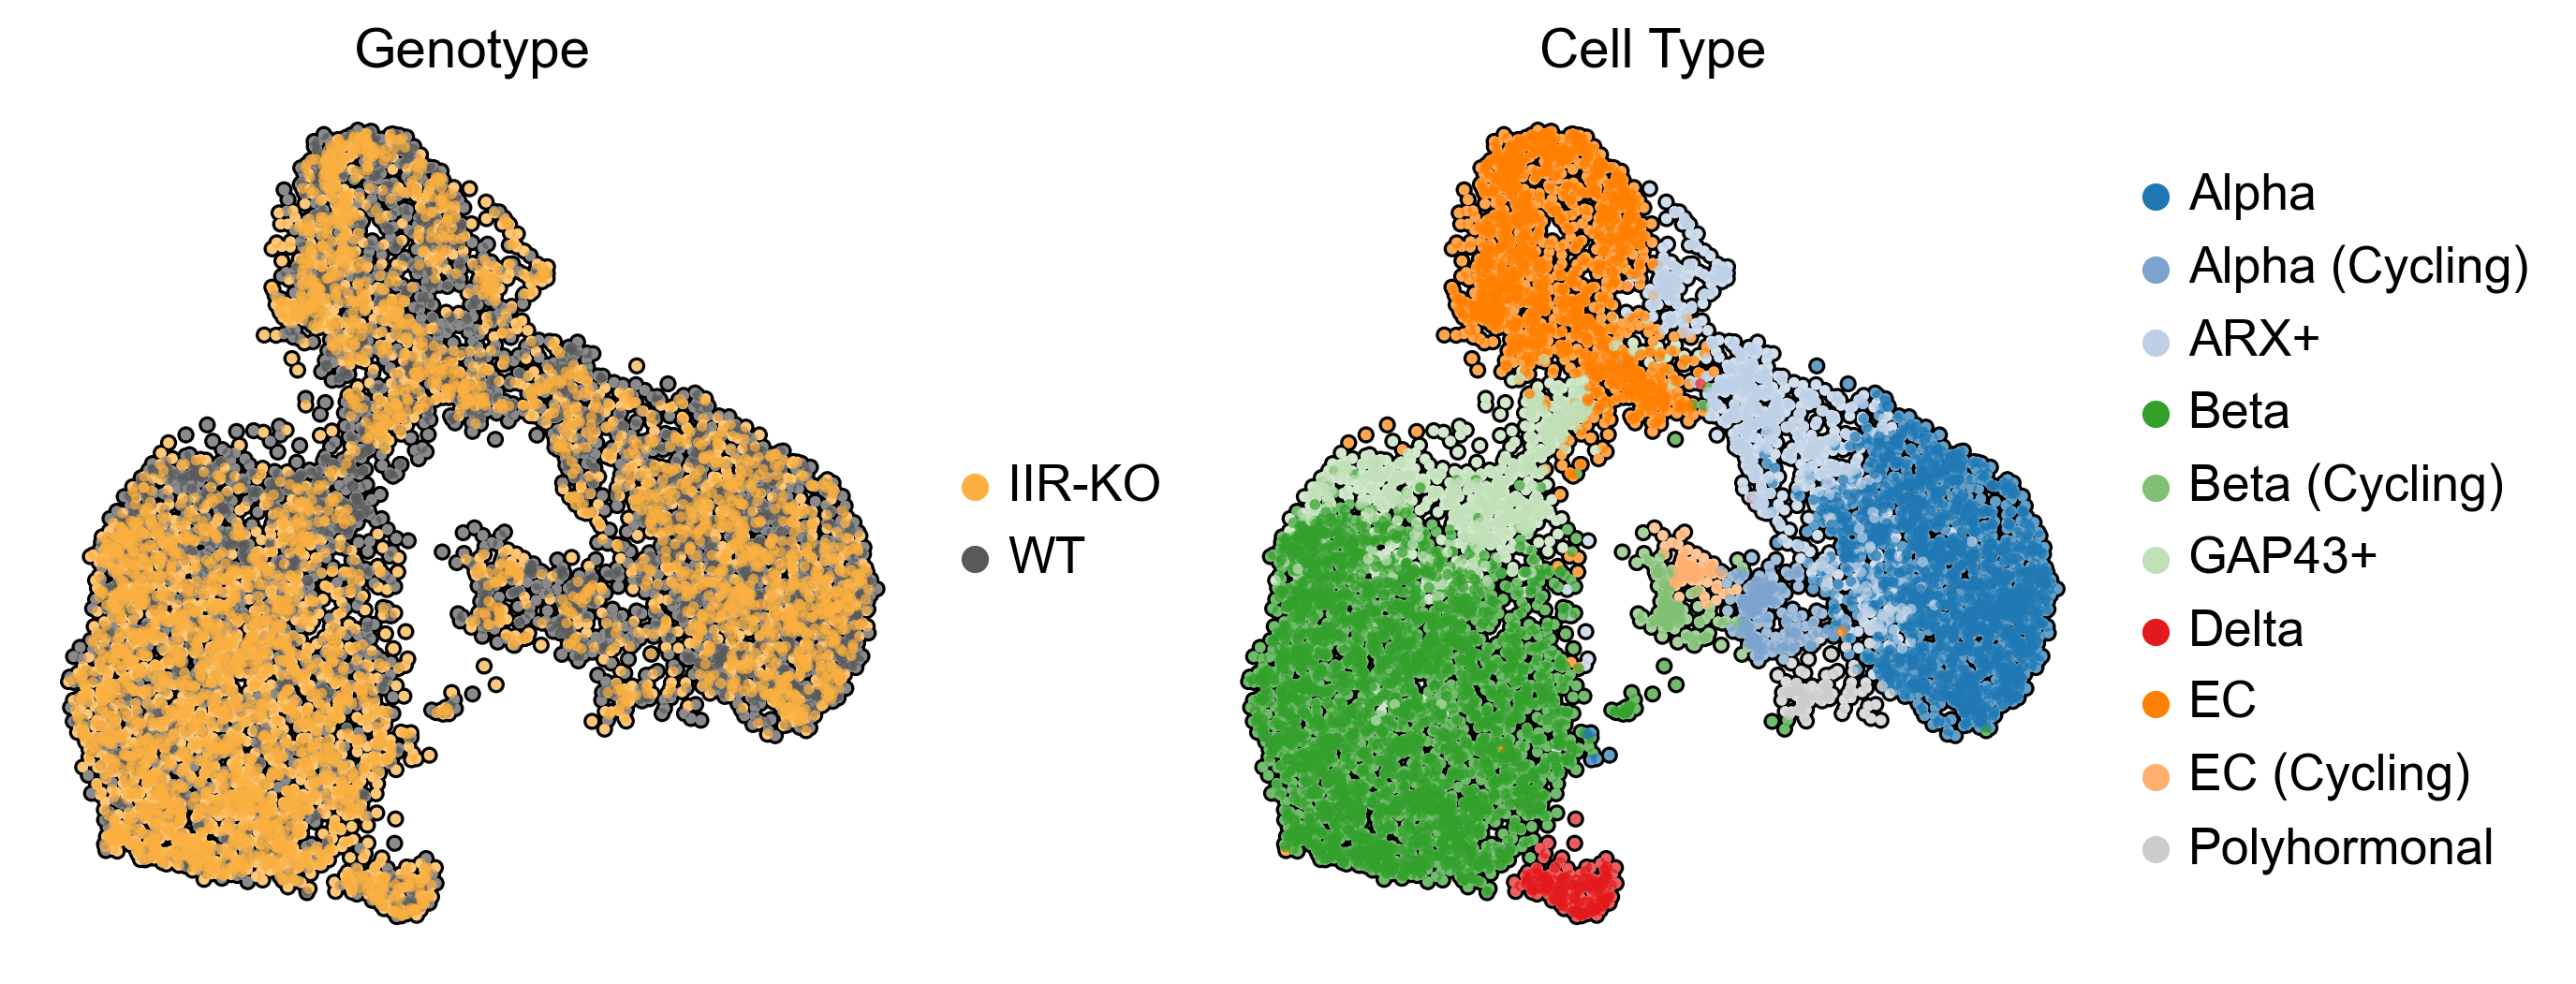

In [18]:
sc.pl.umap(adata, color=['genotype','cell_type'], title=['Genotype','Cell Type'], size=30, add_outline=True, alpha=0.7, outline_width=(0.3, 0.0), ncols=4, save='_umap_endocrine_genotype.pdf')

maxp pruned
LTSH dropped
cmap pruned
kern dropped
post pruned
PCLT dropped
GPOS pruned
GSUB pruned
JSTF dropped
DSIG dropped
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 40 glyphs before
Glyph names: ['.notdef', 'A', 'B', 'C', 'D', 'E', 'G', 'I', 'K', 'M', 'O', 'P', 'R', 'T', 'W', 'X', 'a', 'c', 'e', 'four', 'g', 'glyph00001', 'glyph00002', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'o', 'p', 'parenleft', 'parenright', 'plus', 'r', 's', 'space', 't', 'three', 'y']
Glyph IDs:   [0, 1, 2, 3, 11, 12, 14, 16, 22, 23, 36, 37, 38, 39, 40, 42, 44, 46, 48, 50, 51, 53, 55, 58, 59, 68, 70, 72, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 92]
Closed glyph list over 'GSUB': 45 glyphs after
Glyph names: ['.notdef', 'A', 'B', 'C', 'D', 'E', 'G', 'I', 'K', 'M', 'O', 'P', 'R', 'T', 'W', 'X', 'a', 'c', 'e', 'four', 'g', 'glyph00001', 'glyph00002', 'glyph03464', 'glyph03677', 'glyph03678', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'o', 'p', 'parenleft', 

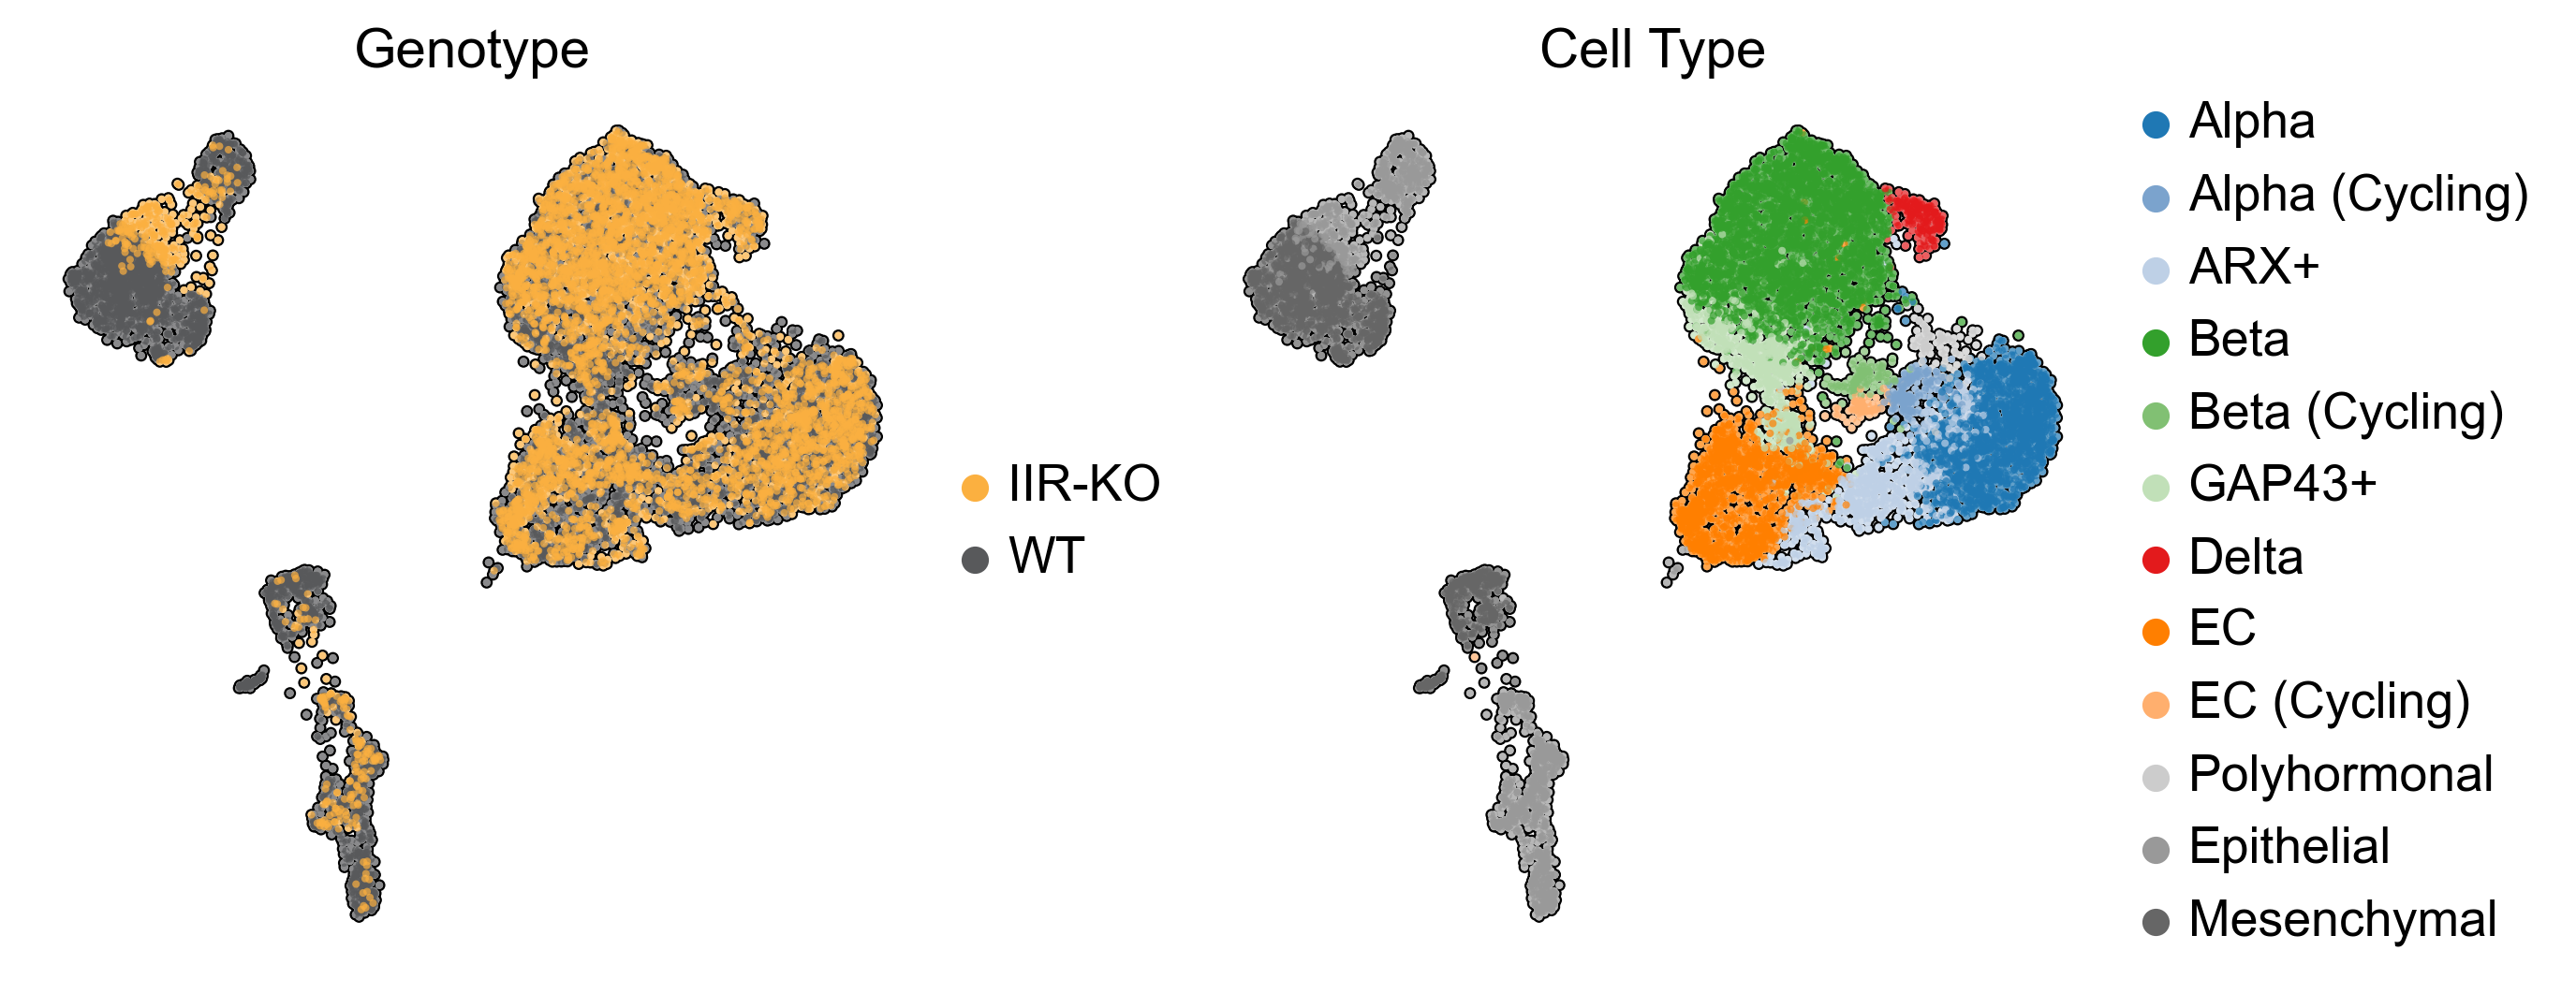

In [19]:
sc.pl.umap(adata_all, color=['genotype','cell_type'], title=['Genotype','Cell Type'], size=15, add_outline=True, alpha=0.7, outline_width=(0.3, 0.0), ncols=4, save='_umap_all_genotype.pdf')

In [20]:
adata.obs['sample'].value_counts()

S6_IIR-KO    4368
S6_WT        3931
Name: sample, dtype: int64

# Marker Genes

In [21]:
sc.tl.rank_genes_groups(adata_all, groupby='cell_type')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


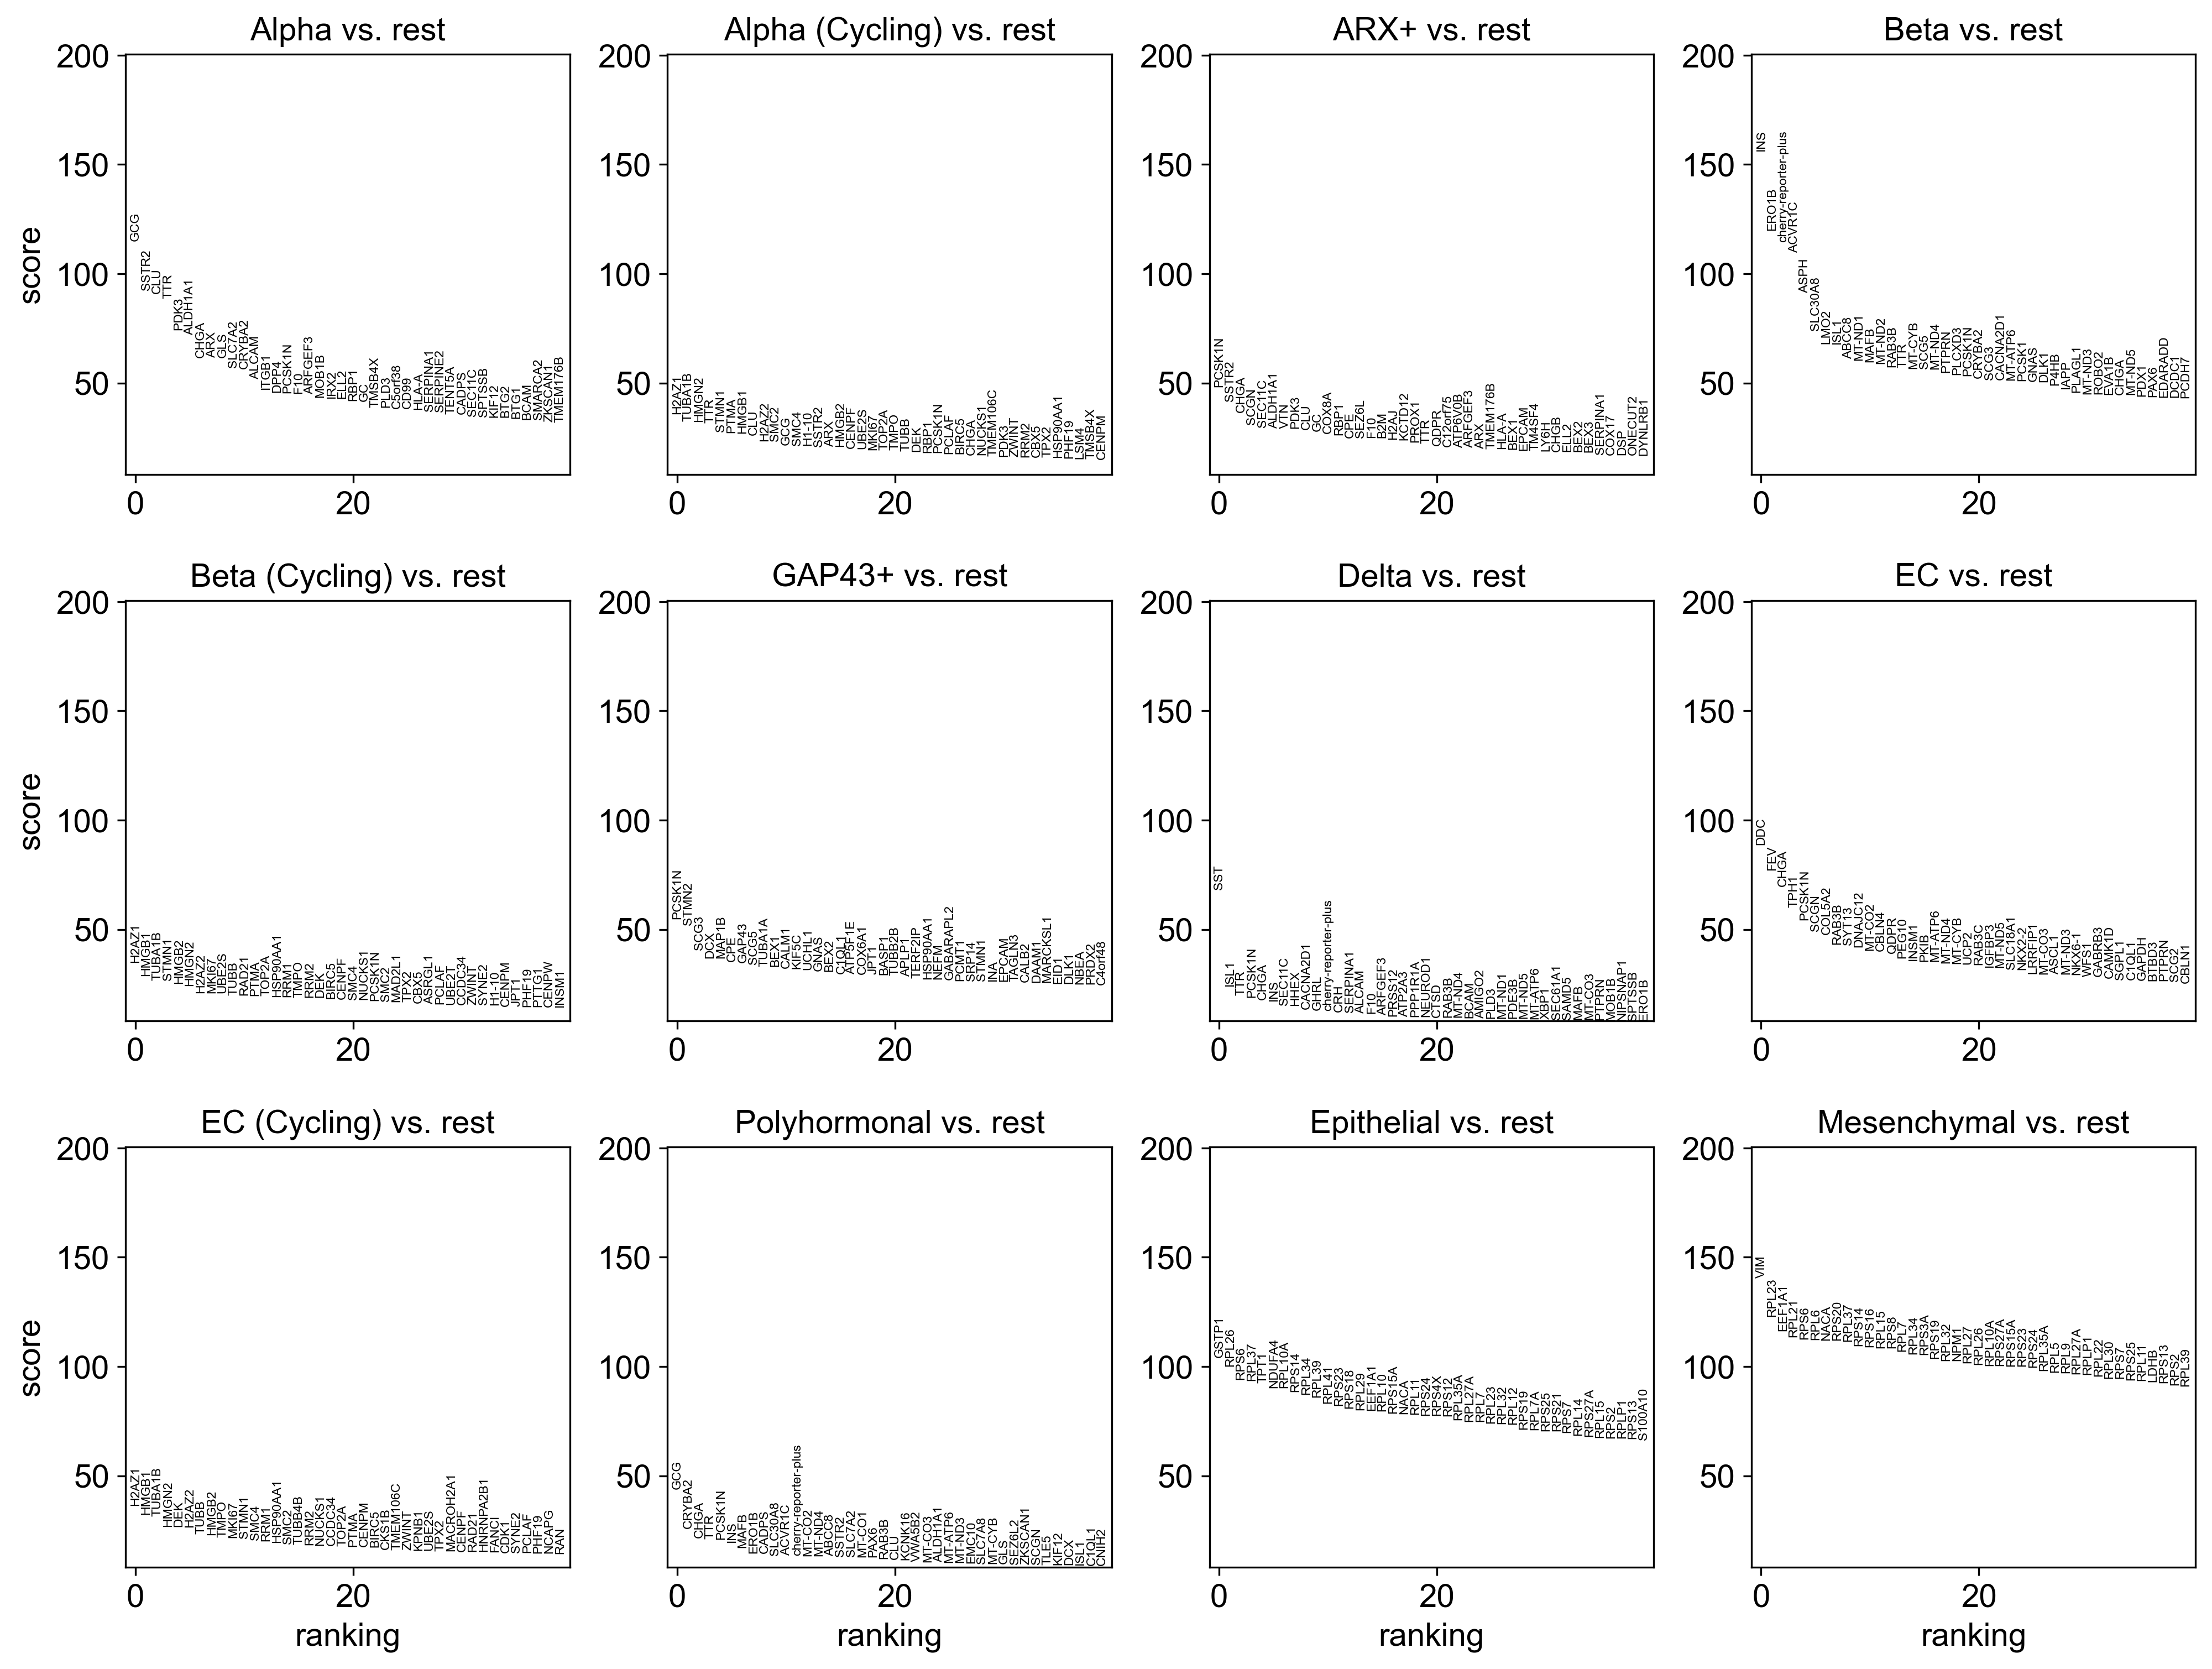

In [22]:
sc.pl.rank_genes_groups(adata_all, n_genes=40, fontsize=5.5)

In [24]:
marker_genes = ['GCG','ARX','INS','GAP43','SST','TPH1','MKI67','EPCAM','VIM']

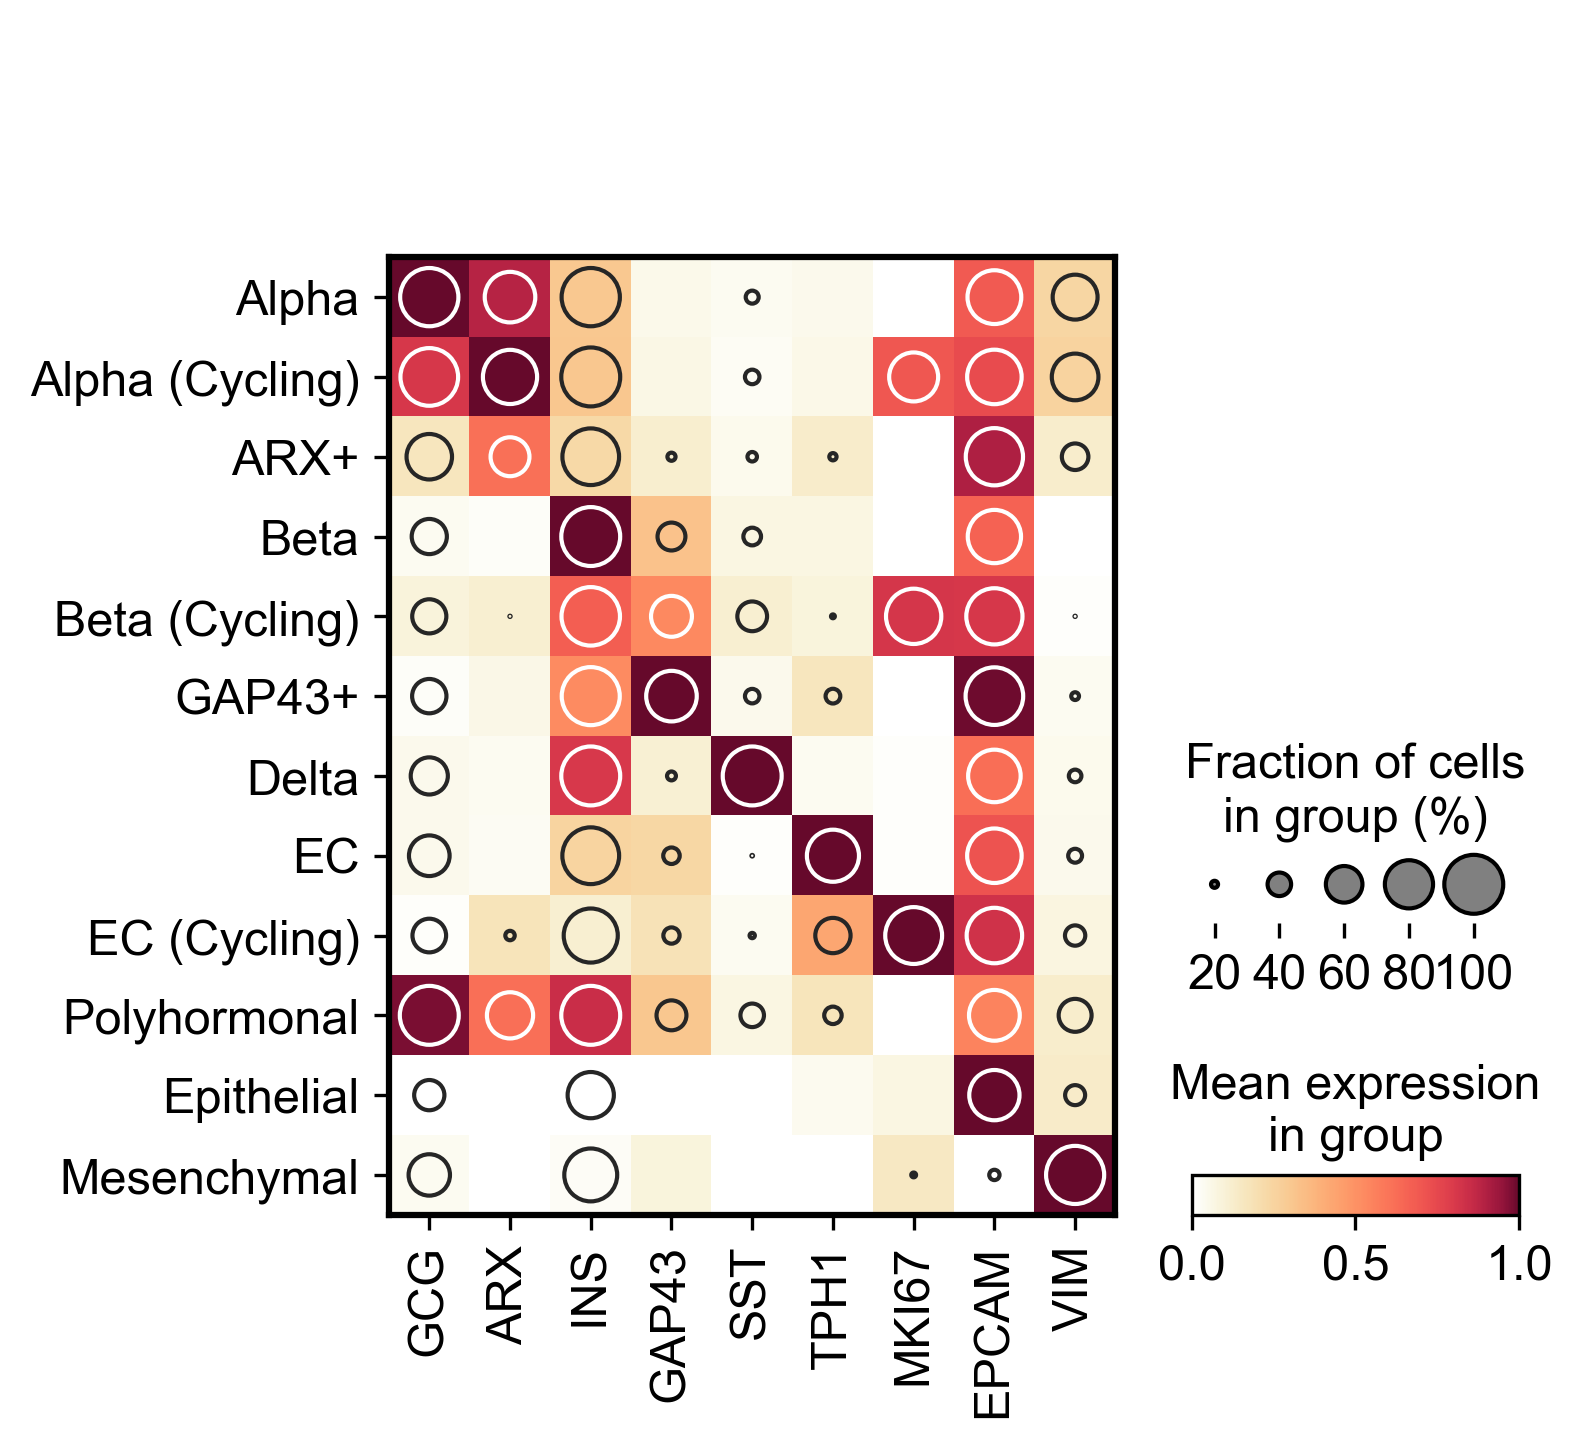

In [25]:
sc.pl.DotPlot(adata_all, var_names=marker_genes, groupby='cell_type', standard_scale='var', cmap=ch_YlRd, use_raw=False).style(color_on='square', dot_edge_lw=1, grid=True, dot_min=0.15, dot_edge_color=None).show()

maxp pruned
LTSH dropped
cmap pruned
kern dropped
post pruned
PCLT dropped
GPOS pruned
GSUB pruned
JSTF dropped
DSIG dropped
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 53 glyphs before
Glyph names: ['.notdef', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'K', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'V', 'W', 'X', 'a', 'c', 'e', 'eight', 'five', 'four', 'g', 'glyph00001', 'glyph00002', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'plus', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'underscore', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 11, 12, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 36, 37, 38, 39, 40, 42, 43, 44, 46, 48, 49, 50, 51, 53, 54, 55, 57, 58, 59, 66, 68, 70, 72, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 92]
Closed glyph list over 'GSUB': 72 glyphs after
Glyph names: ['.notdef', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'K', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 

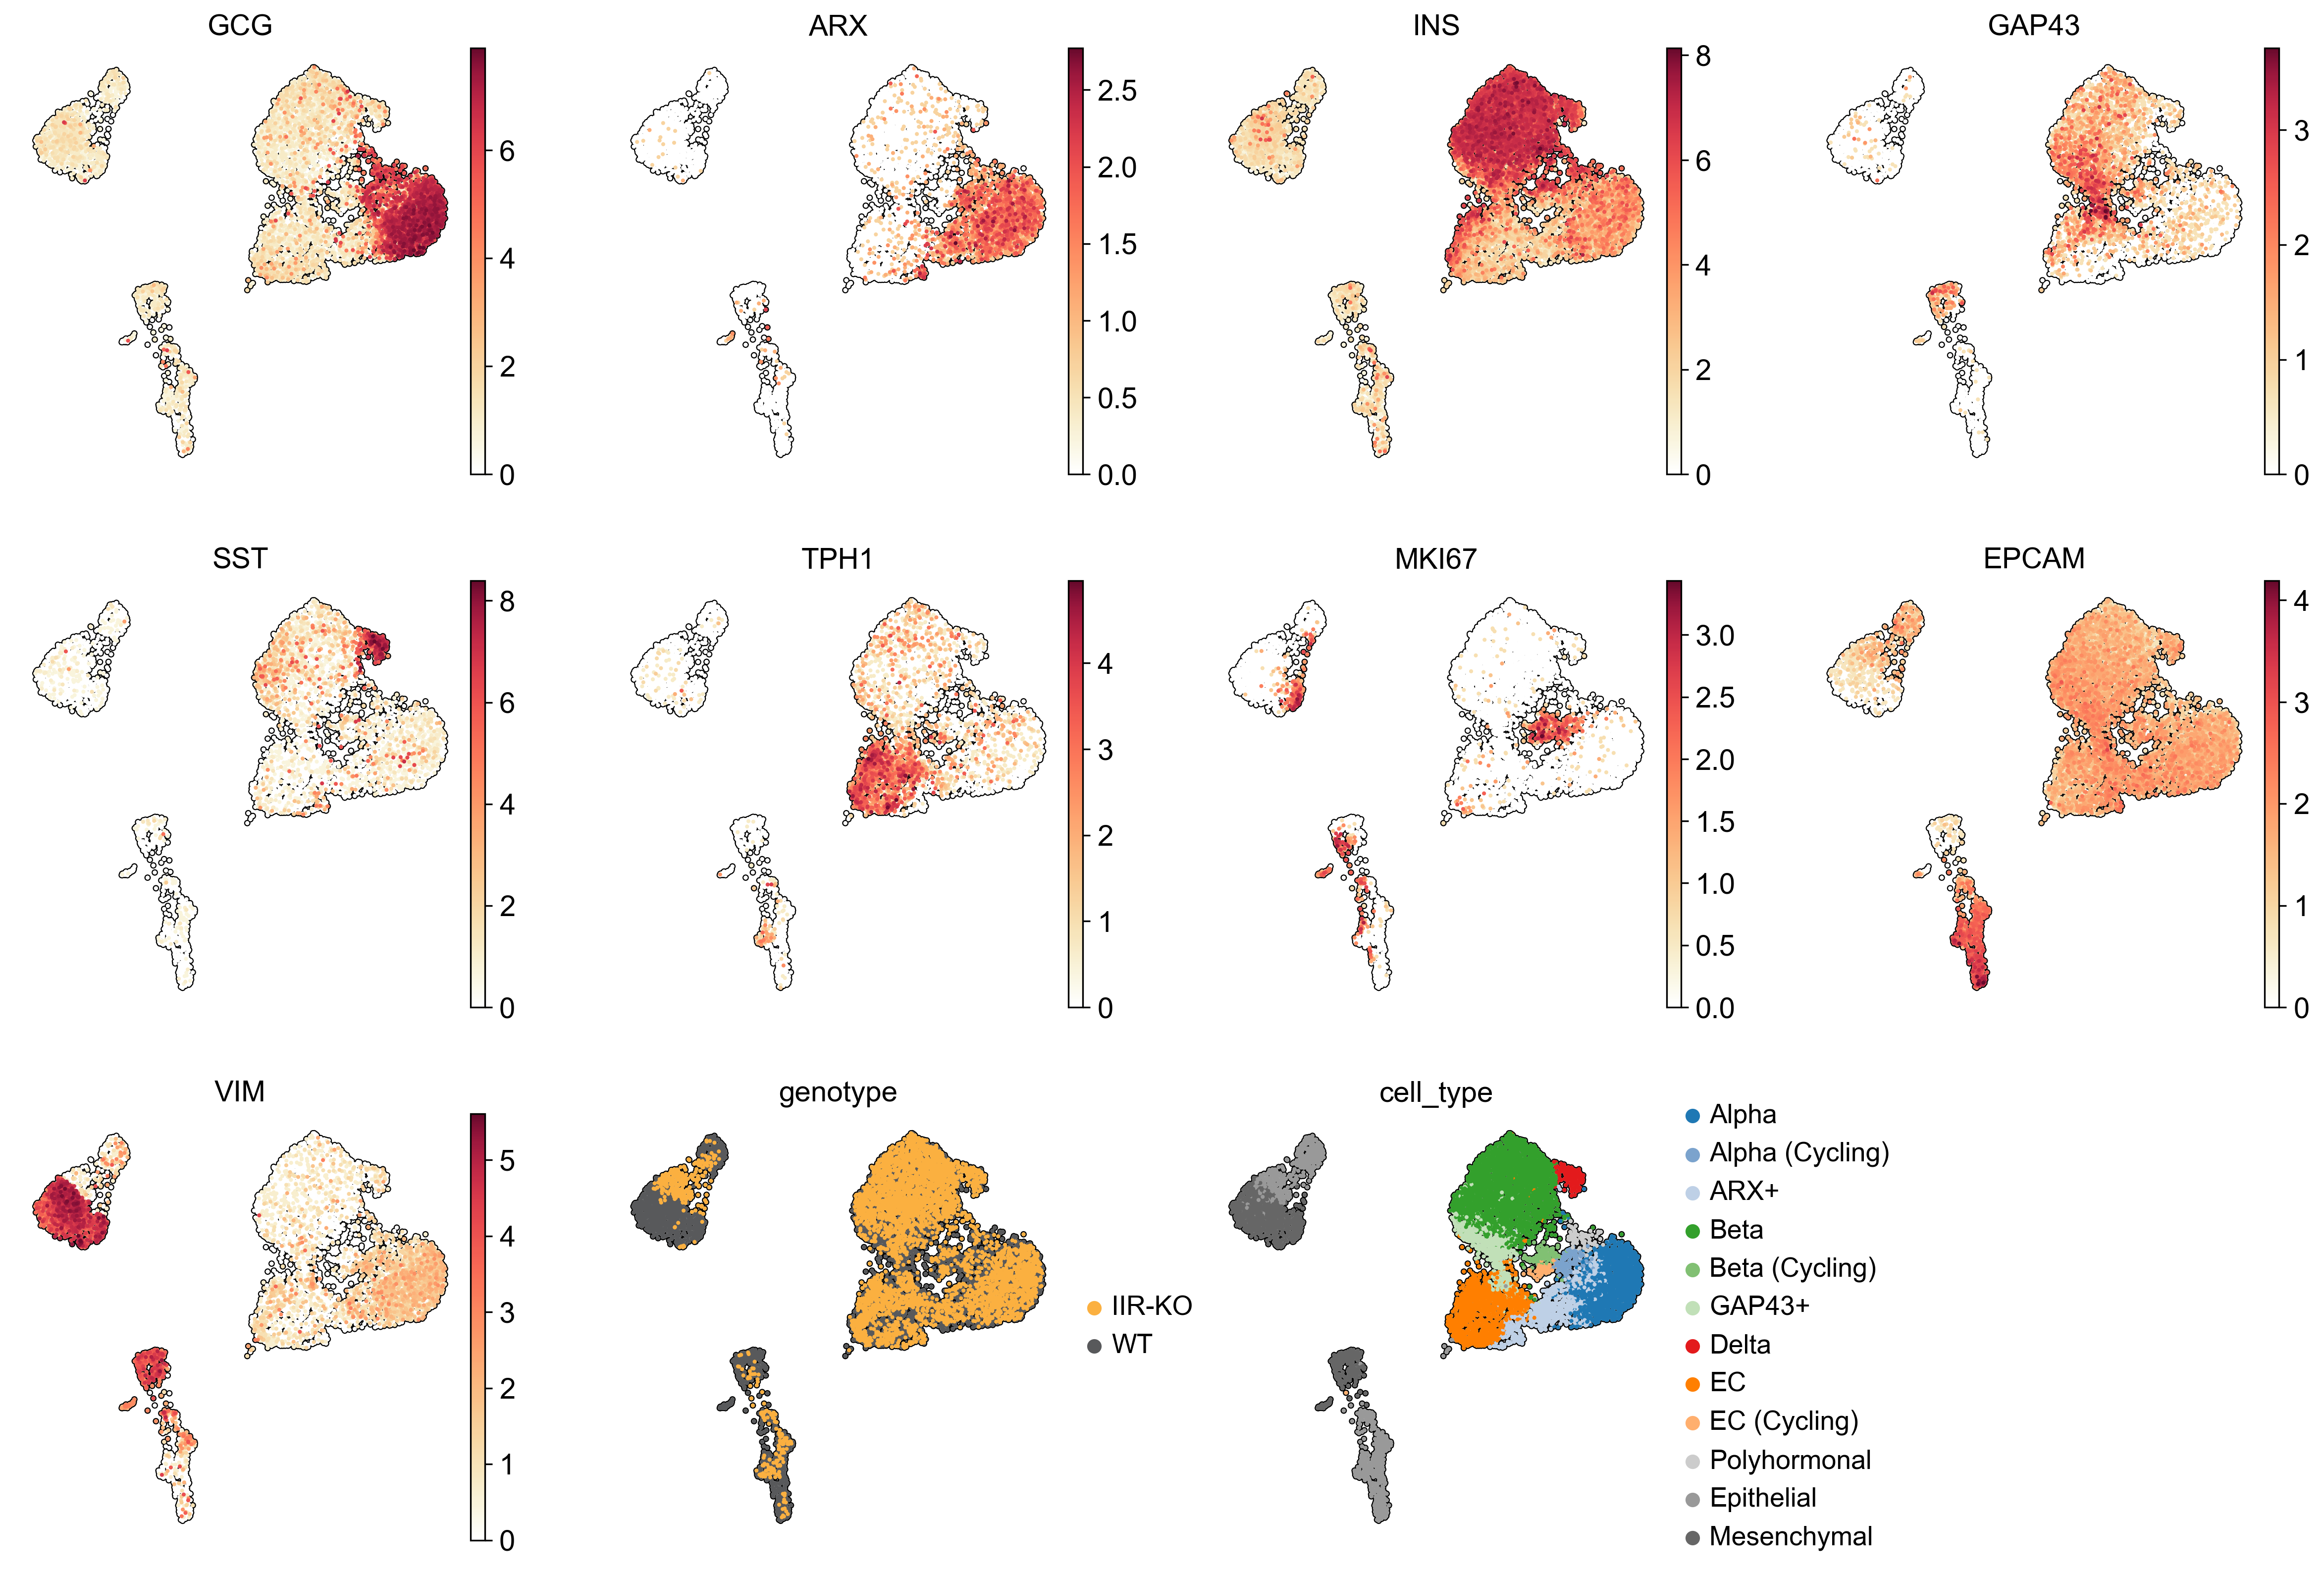

In [26]:
sc.pl.umap(adata_all, color=marker_genes + ['genotype','cell_type'], size=15, add_outline=True, alpha=1, outline_width=(0.3, 0.0), ncols=4, cmap=ch_YlRd, save='_umap_all_marker_genes.pdf')

# Composition

## All Cells

maxp pruned
LTSH dropped
cmap pruned
kern dropped
post pruned
PCLT dropped
GPOS pruned
GSUB pruned
JSTF dropped
DSIG dropped
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 48 glyphs before
Glyph names: ['.notdef', 'A', 'B', 'C', 'D', 'E', 'G', 'I', 'K', 'M', 'O', 'P', 'R', 'T', 'W', 'X', 'a', 'b', 'c', 'e', 'eight', 'four', 'g', 'glyph00001', 'glyph00002', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'o', 'one', 'p', 'parenleft', 'parenright', 'percent', 'plus', 'r', 's', 'six', 'space', 't', 'three', 'two', 'underscore', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 8, 11, 12, 14, 16, 19, 20, 21, 22, 23, 25, 27, 36, 37, 38, 39, 40, 42, 44, 46, 48, 50, 51, 53, 55, 58, 59, 66, 68, 69, 70, 72, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 92]
Closed glyph list over 'GSUB': 63 glyphs after
Glyph names: ['.notdef', 'A', 'B', 'C', 'D', 'E', 'G', 'I', 'K', 'M', 'O', 'P', 'R', 'T', 'W', 'X', 'a', 'b', 'c', 'e', 'eight', 'four', 'g', 'glyph00001', '

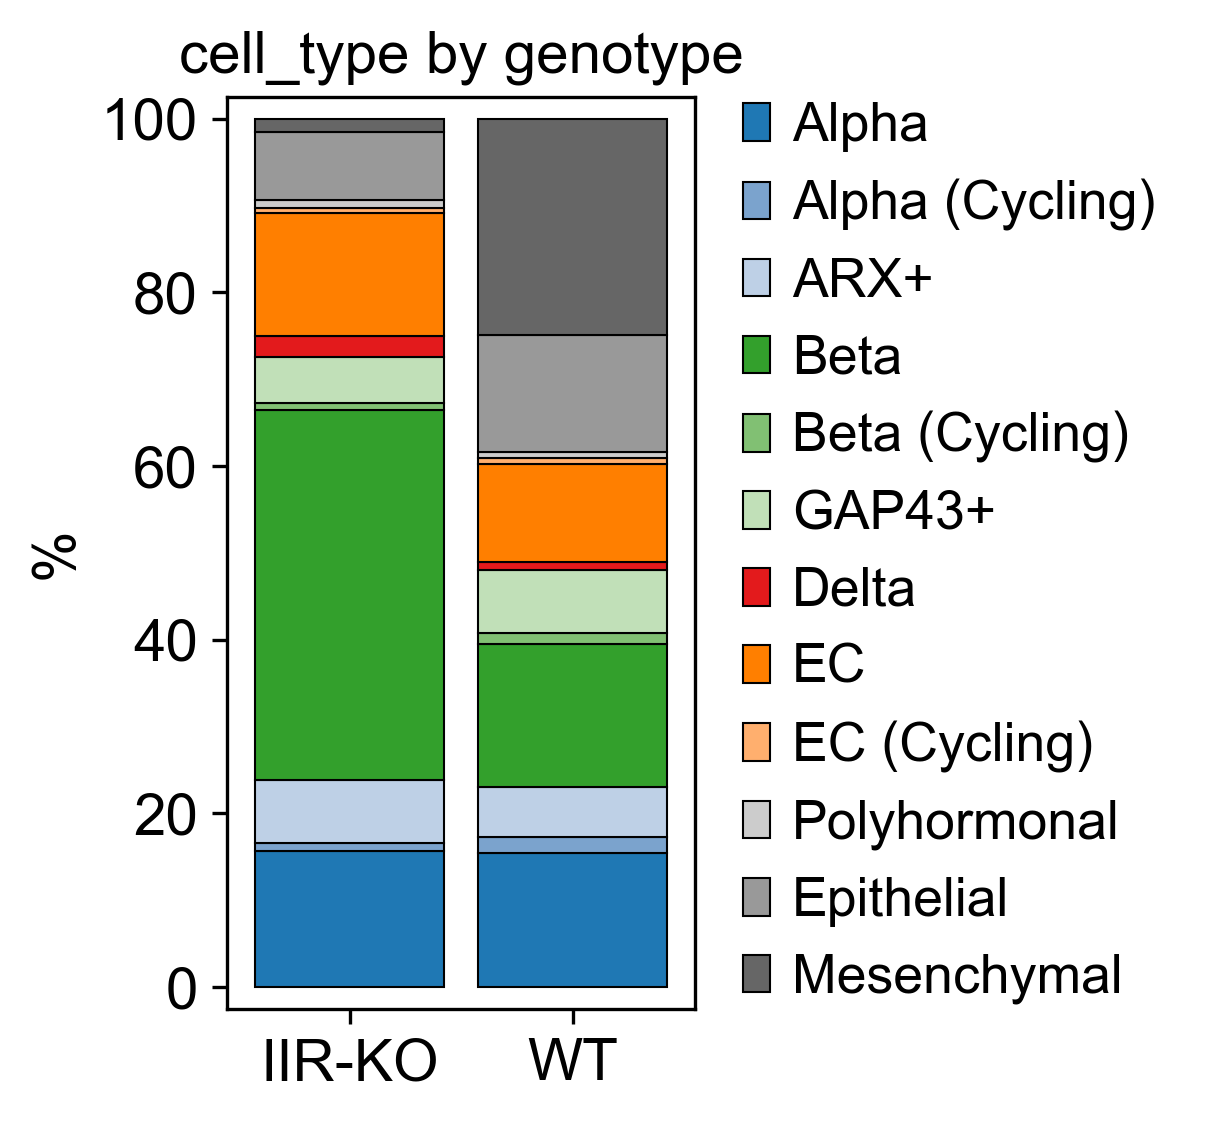

x_labels      Alpha  Alpha (Cycling)      ARX+       Beta  Beta (Cycling)  \
0   IIR-KO  15.619166         1.016387  7.218419  42.646754        0.788218   
1       WT  15.435294         1.850980  5.788235  16.454902        1.223529   

     GAP43+     Delta        EC  EC (Cycling)  Polyhormonal  Epithelial  \
0  5.268616  2.406140  14.20867      0.580792      0.850446    7.902925   
1  7.231373  0.909804  11.32549      0.752941      0.690196   13.443137   

   Mesenchymal  
0     1.493466  
1    24.894118

In [30]:
plot_composition(adata_all, x_key='genotype', y_key='cell_type', x_rotation=0, figsize=(2,4), save='/mnt/ssd/Projects/scRNA-seq_iPSC_IGFRL-KO_Notebooks/Figures/barplot_composition_all_cell_type_vs_genotype.pdf')

## Endocrine Cells

maxp pruned
LTSH dropped
cmap pruned
kern dropped
post pruned
PCLT dropped
GPOS pruned
GSUB pruned
JSTF dropped
DSIG dropped
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 46 glyphs before
Glyph names: ['.notdef', 'A', 'B', 'C', 'D', 'E', 'G', 'I', 'K', 'O', 'P', 'R', 'T', 'W', 'X', 'a', 'b', 'c', 'e', 'eight', 'four', 'g', 'glyph00001', 'glyph00002', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'o', 'one', 'p', 'parenleft', 'parenright', 'percent', 'plus', 'r', 'six', 'space', 't', 'three', 'two', 'underscore', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 8, 11, 12, 14, 16, 19, 20, 21, 22, 23, 25, 27, 36, 37, 38, 39, 40, 42, 44, 46, 50, 51, 53, 55, 58, 59, 66, 68, 69, 70, 72, 74, 75, 76, 79, 80, 81, 82, 83, 85, 87, 92]
Closed glyph list over 'GSUB': 61 glyphs after
Glyph names: ['.notdef', 'A', 'B', 'C', 'D', 'E', 'G', 'I', 'K', 'O', 'P', 'R', 'T', 'W', 'X', 'a', 'b', 'c', 'e', 'eight', 'four', 'g', 'glyph00001', 'glyph00002', 'glyph0346

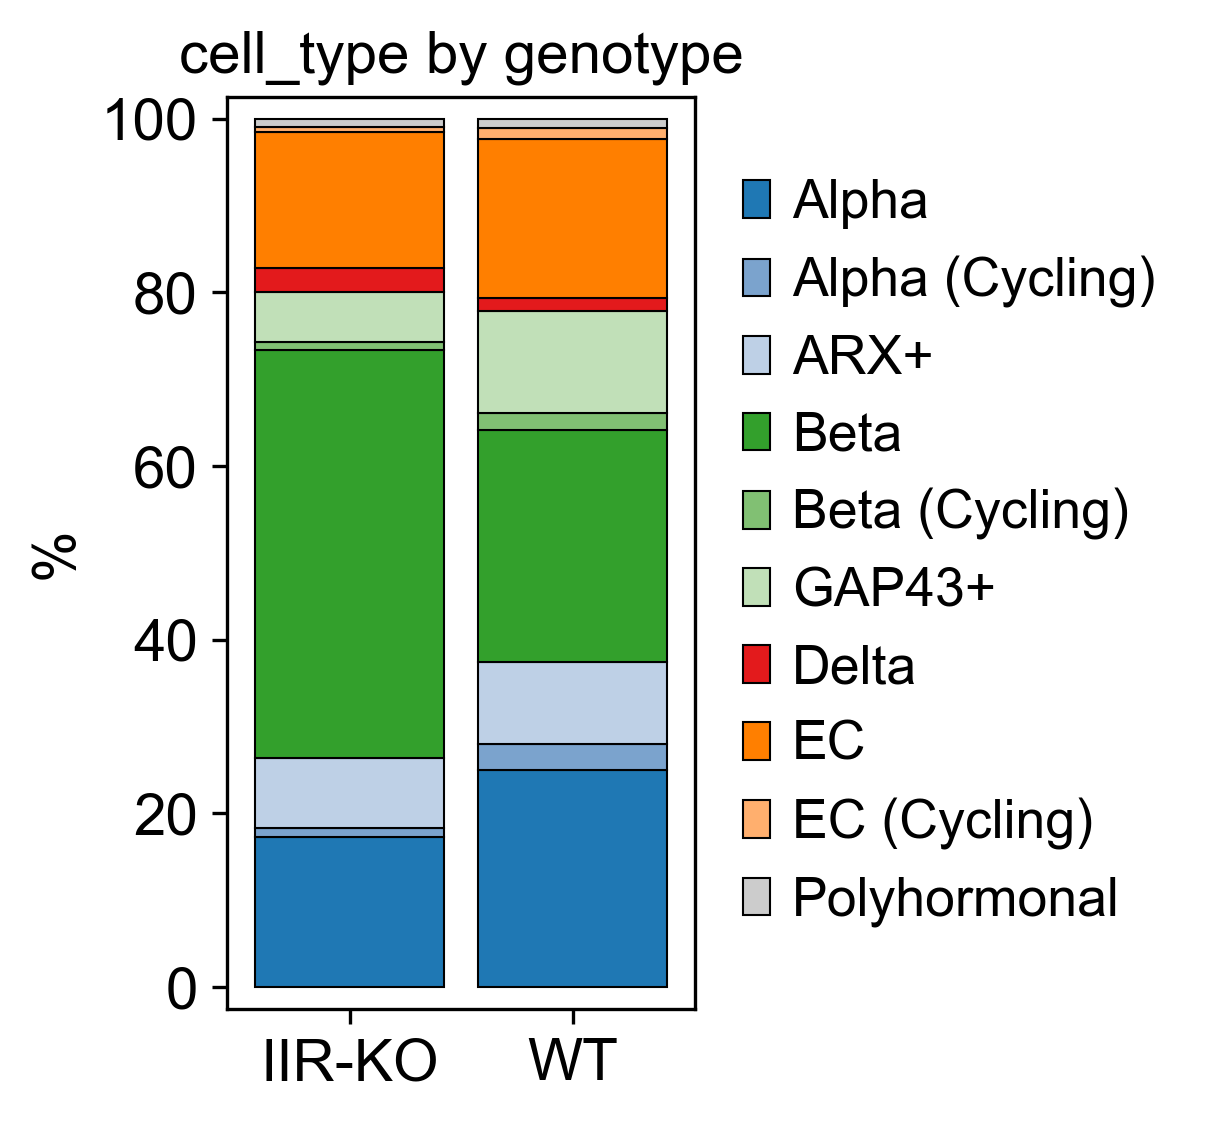

x_labels      Alpha  Alpha (Cycling)      ARX+       Beta  Beta (Cycling)  \
0   IIR-KO  17.239011         1.121795  7.967033  47.069597        0.869963   
1       WT  25.031799         3.001781  9.386924  26.685322        1.984228   

      GAP43+     Delta         EC  EC (Cycling)  Polyhormonal  
0   5.815018  2.655678  15.682234      0.641026      0.938645  
1  11.727296  1.475452  18.366828      1.221063      1.119308

In [32]:
plot_composition(adata, x_key='genotype', y_key='cell_type', x_rotation=0, figsize=(2,4), save='/mnt/ssd/Projects/scRNA-seq_iPSC_IGFRL-KO_Notebooks/Figures/barplot_composition_endocrine_cell_type_vs_genotype.pdf')

## Embedding Densities

### Endocrine Cells

In [33]:
sc.tl.embedding_density(adata, basis='umap', groupby='genotype', key_added='genotype_density')

computing density on 'umap'
--> added
    'genotype_density', densities (adata.obs)
    'genotype_density_params', parameter (adata.uns)


#### KDE Plots

maxp pruned
LTSH dropped
cmap pruned
kern dropped
post pruned
PCLT dropped
GPOS pruned
GSUB pruned
JSTF dropped
DSIG dropped
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 17 glyphs before
Glyph names: ['.notdef', 'C', 'E', 'I', 'P', 'R', 'e', 'glyph00001', 'glyph00002', 'h', 'hyphen', 'minus', 'r', 'semicolon', 'slash', 'space', 'y']
Glyph IDs:   [0, 1, 2, 3, 16, 18, 30, 38, 40, 44, 51, 53, 72, 75, 85, 92, 237]
Closed glyph list over 'GSUB': 18 glyphs after
Glyph names: ['.notdef', 'C', 'E', 'I', 'P', 'R', 'e', 'fraction', 'glyph00001', 'glyph00002', 'h', 'hyphen', 'minus', 'r', 'semicolon', 'slash', 'space', 'y']
Glyph IDs:   [0, 1, 2, 3, 16, 18, 30, 38, 40, 44, 51, 53, 72, 75, 85, 92, 187, 237]
Closing glyph list over 'glyf': 18 glyphs before
Glyph names: ['.notdef', 'C', 'E', 'I', 'P', 'R', 'e', 'fraction', 'glyph00001', 'glyph00002', 'h', 'hyphen', 'minus', 'r', 'semicolon', 'slash', 'space', 'y']
Glyph IDs:   [0, 1, 

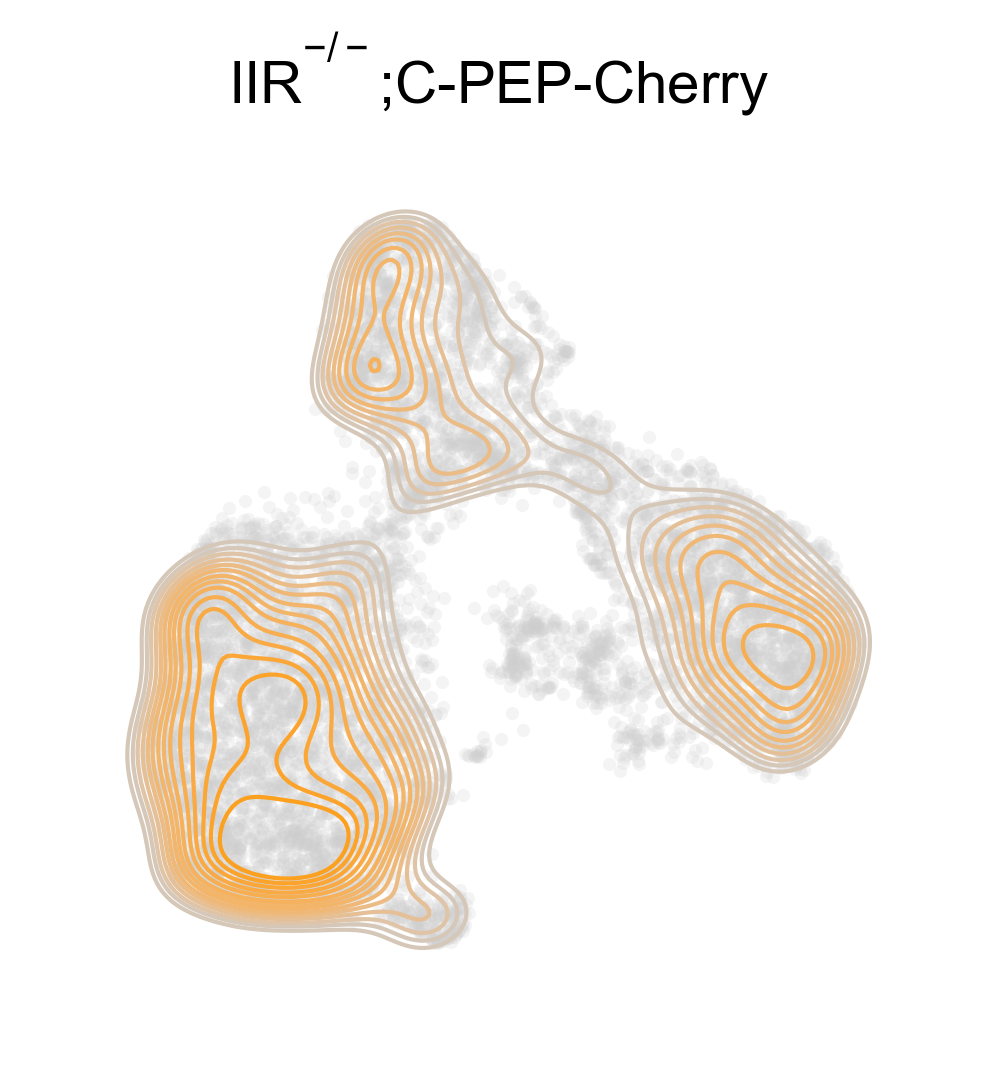

In [35]:
x=pd.DataFrame(adata.obsm['X_umap'])[0]
y=pd.DataFrame(adata.obsm['X_umap'])[1]
ax=sb.scatterplot(x=x, 
                  y=y,
                  color='#cccccc',
                  s=10,
                  linewidth=0, alpha=0.2)

# x=pd.DataFrame(adata[adata.obs.genotype.isin(['WT'])].obsm['X_umap'])[0]
# y=pd.DataFrame(adata[adata.obs.genotype.isin(['WT'])].obsm['X_umap'])[1]
# sb.kdeplot(x=x, y=y, levels=10, color='#377eb8', linewidths=1, bw_adjust=0.5,
#                   ax=ax)

x=pd.DataFrame(adata[adata.obs.genotype.isin(['IIR-KO'])].obsm['X_umap'])[0]
y=pd.DataFrame(adata[adata.obs.genotype.isin(['IIR-KO'])].obsm['X_umap'])[1]
sb.kdeplot(x=x, y=y, levels=15, color='#d30010', linewidths=1, bw_adjust=0.75, thresh=0.20, cmap=cm_KO,
                  ax=ax)

ax.set_frame_on(False)
ax.set(xlabel='')
ax.set(xticklabels=[]) 
ax.set(ylabel='')
ax.set(yticklabels=[]) 
ax.tick_params(bottom=False, left=False)
ax.set(title='IIR$^{-/-}$;C-PEP-Cherry')
plt.savefig('/home/michi/Projects/scRNA-seq_iPSC_IGFRL-KO_Notebooks/Figures/density_IIR-KO.pdf')

maxp pruned
LTSH dropped
cmap pruned
kern dropped
post pruned
PCLT dropped
GPOS pruned
GSUB pruned
JSTF dropped
DSIG dropped
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 17 glyphs before
Glyph names: ['.notdef', 'C', 'E', 'I', 'P', 'R', 'e', 'glyph00001', 'glyph00002', 'h', 'hyphen', 'plus', 'r', 'semicolon', 'slash', 'space', 'y']
Glyph IDs:   [0, 1, 2, 3, 14, 16, 18, 30, 38, 40, 44, 51, 53, 72, 75, 85, 92]
Closed glyph list over 'GSUB': 18 glyphs after
Glyph names: ['.notdef', 'C', 'E', 'I', 'P', 'R', 'e', 'fraction', 'glyph00001', 'glyph00002', 'h', 'hyphen', 'plus', 'r', 'semicolon', 'slash', 'space', 'y']
Glyph IDs:   [0, 1, 2, 3, 14, 16, 18, 30, 38, 40, 44, 51, 53, 72, 75, 85, 92, 187]
Closing glyph list over 'glyf': 18 glyphs before
Glyph names: ['.notdef', 'C', 'E', 'I', 'P', 'R', 'e', 'fraction', 'glyph00001', 'glyph00002', 'h', 'hyphen', 'plus', 'r', 'semicolon', 'slash', 'space', 'y']
Glyph IDs:   [0, 1, 2, 3,

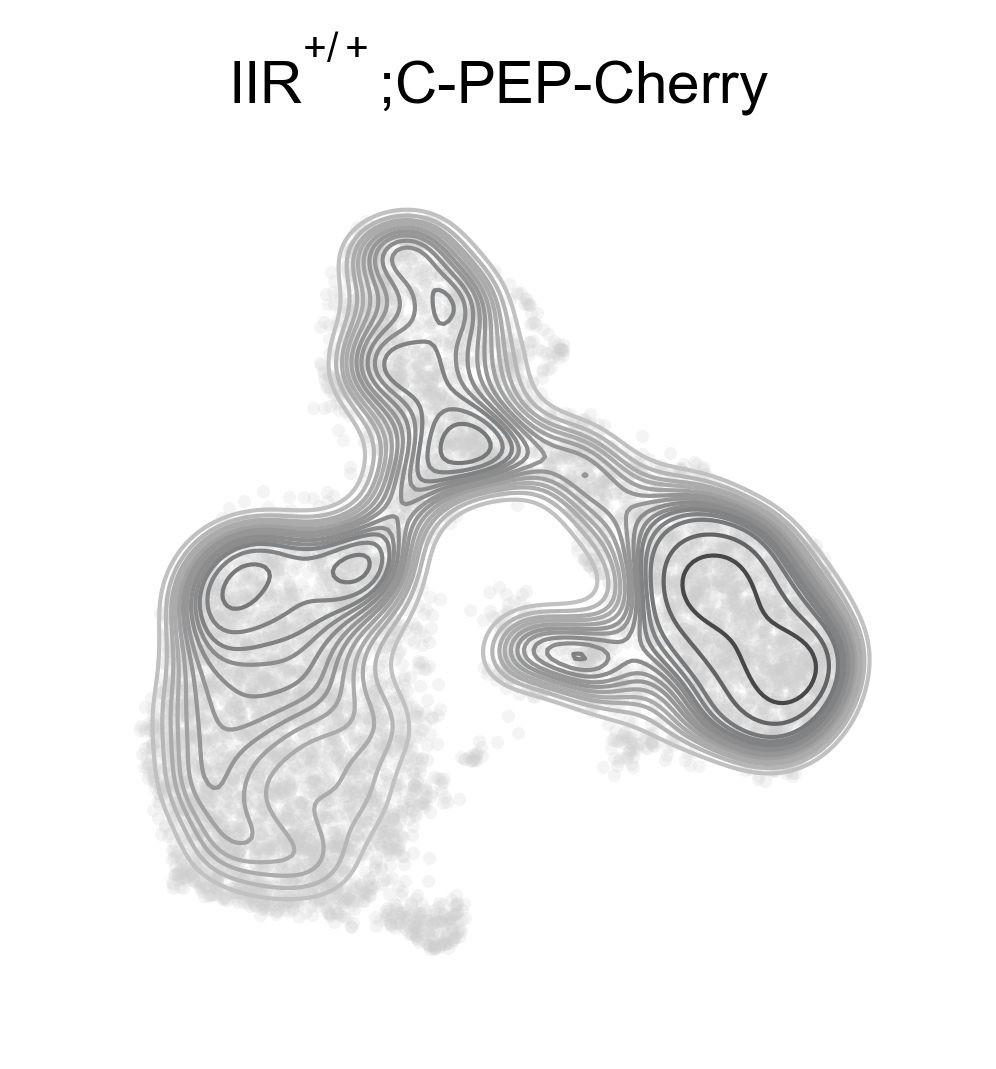

In [36]:
x=pd.DataFrame(adata.obsm['X_umap'])[0]
y=pd.DataFrame(adata.obsm['X_umap'])[1]
ax=sb.scatterplot(x=x, 
                  y=y,
                  color='#cccccc',
                  s=10,
                  linewidth=0, alpha=0.2)

x=pd.DataFrame(adata[adata.obs.genotype.isin(['WT'])].obsm['X_umap'])[0]
y=pd.DataFrame(adata[adata.obs.genotype.isin(['WT'])].obsm['X_umap'])[1]
sb.kdeplot(x=x, y=y, levels=15, color='#377eb8', linewidths=1, bw_adjust=0.75, thresh=0.20, cmap=cm_WT,
                  ax=ax)

# x=pd.DataFrame(adata[adata.obs.genotype.isin(['IIR-KO'])].obsm['X_umap'])[0]
# y=pd.DataFrame(adata[adata.obs.genotype.isin(['IIR-KO'])].obsm['X_umap'])[1]
# sb.kdeplot(x=x, y=y, levels=10, color='#d30010', linewidths=1, bw_adjust=0.5,
#                   ax=ax)

ax.set_frame_on(False)
ax.set(xlabel='')
ax.set(xticklabels=[]) 
ax.set(ylabel='')
ax.set(yticklabels=[]) 
ax.tick_params(bottom=False, left=False)
ax.set(title='IIR$^{+/+}$;C-PEP-Cherry')
plt.savefig('/home/michi/Projects/scRNA-seq_iPSC_IGFRL-KO_Notebooks/Figures/density_WT.pdf')